In [5]:
from neural_networks.cnn import Model as CNNModel
from neural_networks.lstm import Model as LSTMModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from typing import Tuple
from sklearn.preprocessing import StandardScaler

def graph_results_model(history):
    """The function `graph_results_model` plots the training and validation loss over epochs.

    Parameters
    ----------
    history
        The "history" parameter is the object returned by the "fit" method when training a machine
        learning model. It contains information about the training process, such as the loss values
        and metrics at each epoch.

    """
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def generate_prediction(model, dirty_data_test_reshaped, clean_data_test_reshaped):
    """The function `generate_prediction` takes a machine learning model, dirty and clean test data,
    and generates predictions for the clean data, along with evaluating the performance
    of the predictions using mean squared error, root mean squared error, mean absolute error,
    and Pearson's correlation coefficient.

    Parameters
    ----------
    model
        The `model` parameter is the trained machine learning model that will be used to generate predictions.
    dirty_data_test_reshaped
        The variable `dirty_data_test_reshaped` represents the reshaped dirty test data.
        It is the input data that you want to use to generate predictions.
    clean_data_test_reshaped
        The variable `clean_data_test_reshaped` is a numpy array that contains the reshaped clean
        test data. It should have the shape `(num_samples, num_features)`, where `num_samples`
        is the number of samples in the test data and `num_features` is the number of features
    """
    mse_values = []
    rmse_values = []
    mae_values = []
    corr_values = []

    global scaler

    y_pred = model.predict(dirty_data_test_reshaped)
    y_pred = np.squeeze(y_pred)
    print(y_pred.shape)

    for signal_number in range(dirty_data_test_reshaped.shape[0]):
        real_clean_signal = clean_data_test_reshaped[signal_number]
        predicted_clean_signal = y_pred[signal_number]

        real_clean_signal_inv = scaler.inverse_transform(real_clean_signal)
        predicted_clean_signal_inv = scaler.inverse_transform(predicted_clean_signal)

        real_clean_signal_single = real_clean_signal_inv[0, :]
        predicted_clean_signal_single = predicted_clean_signal_inv[0, :]

        mse = mean_squared_error(
            real_clean_signal_single, predicted_clean_signal_single
        )
        mse_values.append(mse)

        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

        mae = mean_absolute_error(
            real_clean_signal_single, predicted_clean_signal_single
        )
        mae_values.append(mae)

        corr, _ = pearsonr(real_clean_signal_single, predicted_clean_signal_single)
        corr_values.append(corr)

    mse_mean = np.mean(mse_values)
    rmse_mean = np.mean(rmse_values)
    mae_mean = np.mean(mae_values)
    corr_mean = np.mean(corr_values)

    print("Mean MSE:", mse_mean)
    print("Mean RMSE:", rmse_mean)
    print("Mean MAE:", mae_mean)
    print("Mean Pearson's correlation:", corr_mean)

    plt.figure(figsize=(12, 6))
    plt.plot(real_clean_signal_single, label="Real clean signal")
    plt.plot(predicted_clean_signal_single, label="Predicted clean signal")
    plt.legend()
    plt.title("Comparison of real and predicted clean signals")
    plt.show()


def load_data() -> Tuple[np.ndarray, np.ndarray]:
    """The function `load_data` loads clean and dirty EEG data from two separate files and returns
    them as numpy arrays.

    Returns
    -------
        a tuple containing two numpy arrays: clean_data and dirty_data.
    """
    clean_data = np.load("./datasets/EEG_all_epochs.npy")
    dirty_data = np.load("./datasets/EEG_contaminated_with_EOG_2db.npy")
    return clean_data, dirty_data


def clean_vs_dirty_EEG_graph(clean_data: np.ndarray, dirty_data: np.ndarray):
    """The function `clean_vs_dirty_EEG_graph` plots a comparison between clean and dirty EEG signals.

    Parameters
    ----------
    clean_data
        A numpy array containing the clean EEG data. Each row represents a different EEG signal.
    dirty_data
        The parameter "dirty_data" represents the EEG data that is contaminated or contains noise.

    """
    index = np.random.randint(0, clean_data.shape[0])

    fig, ax = plt.subplots()

    ax.plot(clean_data[index, :], label="EEG Limpio")
    ax.plot(dirty_data[index, :], label="EEG Contaminado")

    ax.set_title("Comparación de señales EEG")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Amplitud")

    ax.legend()
    plt.show()


def create_test_train_data(
    clean_data: np.ndarray,
    dirty_data: np.ndarray,
    tamanio_muestra_test: float = 0.2,
) -> tuple:
    """The function `create_test_train_data` splits clean and dirty data into training and
    testing sets based on the specified test sample size.

    Parameters
    ----------
    clean_data : np.ndarray
        An array containing the clean data samples.
    dirty_data : np.ndarray
        The `dirty_data` parameter is a numpy array that contains the dirty or corrupted data
        that you want to split into training and testing sets.
    tamanio_muestra_test : float
        The parameter "tamanio_muestra_test" represents the proportion of the data that should be
        allocated for testing. It is a float value between 0 and 1, where 0 represents no data for
        testing and 1 represents all data for testing.

    Returns
    -------
        a tuple containing four arrays: clean_data_train, dirty_data_train, clean_data_test,
        and dirty_data_test.

    """
    split_idx = int(len(clean_data) * (1 - tamanio_muestra_test))

    clean_data_train = clean_data[:split_idx]
    dirty_data_train = dirty_data[:split_idx]

    clean_data_test = clean_data[split_idx:]
    dirty_data_test = dirty_data[split_idx:]

    return (
        clean_data_train,
        dirty_data_train,
        clean_data_test,
        dirty_data_test,
    )


def data_processing(
    clean_data_train: np.ndarray,
    dirty_data_train: np.ndarray,
    clean_data_test: np.ndarray,
    dirty_data_test: np.ndarray,
):
    """The function `data_processing` takes in clean and dirty training and testing data,
    normalizes and reshapes the data, and returns the processed data.

    Parameters
    ----------
    clean_data_train
        The parameter `clean_data_train` represents the training data that contains clean or
        normal data samples.
    dirty_data_train
        The parameter `dirty_data_train` represents the training data that contains dirty or
        corrupted samples.
    clean_data_test
        The variable `clean_data_test` represents the clean data for testing. It is a numpy array
        containing the features of the clean test data.
    dirty_data_test
        The parameter `dirty_data_test` represents the test data that contains dirty or corrupted samples.
        It is a numpy array that contains the features of the dirty test data.

    Returns
    -------
        four variables: `clean_data_train_reshaped`, `dirty_data_train_reshaped`,
        `clean_data_test_reshaped`, and `dirty_data_test_reshaped`.

    """
    global scaler
    
    scaler = StandardScaler()
    clean_data_train_normalizados = scaler.fit_transform(clean_data_train)
    dirty_data_train_normalizados = scaler.transform(dirty_data_train)
    clean_data_test_normalizados = scaler.transform(clean_data_test)
    datos_contamindos_de_prueba_normalizados = scaler.transform(dirty_data_test)

    timesteps = 100
    n_samples, n_features = clean_data_train_normalizados.shape
    n_sequences = n_samples // timesteps
    clean_data_train_reshaped = np.reshape(
        clean_data_train_normalizados[: n_sequences * timesteps, :],
        (n_sequences, timesteps, n_features),
    )

    n_samples, n_features = dirty_data_train_normalizados.shape
    n_sequences = n_samples // timesteps
    dirty_data_train_reshaped = np.reshape(
        dirty_data_train_normalizados[: n_sequences * timesteps, :],
        (n_sequences, timesteps, n_features),
    )

    n_samples, n_features = clean_data_test_normalizados.shape
    n_sequences = n_samples // timesteps
    clean_data_test_reshaped = np.reshape(
        clean_data_test_normalizados[: n_sequences * timesteps, :],
        (n_sequences, timesteps, n_features),
    )

    n_samples, n_features = datos_contamindos_de_prueba_normalizados.shape
    n_sequences = n_samples // timesteps
    dirty_data_test_reshaped = np.reshape(
        datos_contamindos_de_prueba_normalizados[: n_sequences * timesteps, :],
        (n_sequences, timesteps, n_features),
    )

    return (
        clean_data_train_reshaped,
        dirty_data_train_reshaped,
        clean_data_test_reshaped,
        dirty_data_test_reshaped,
    )


def prepare_data():
    """The function prepares and processes EEG data by loading, cleaning, visualizing,
    and splitting it into training and testing sets.

    Returns
    -------
        The function `prepare_data` is returning four variables: `clean_data_train_reshaped`,
        The `prepare_data` function is a function that is not defined in the given code. 
        It is likely defined in another file or module. Without the definition of the `prepare_data`
        function, it is not possible to determine exactly what it does. However, based on its name,
        it is likely that the function prepares the data for training and testing the machine learning models. 
        This could involve tasks such as loading the data, preprocessing the data, splitting the 
        data into training and testing sets, and reshaping the data to match the input requirements of the models.
        `dirty_data_train_reshaped`, `clean_data_test_reshaped`, and `dirty_data_test_reshaped`.

    """
    clean_data, dirty_data = load_data()

    clean_vs_dirty_EEG_graph(clean_data, dirty_data)

    (
        clean_data_train,
        dirty_data_train,
        clean_data_test,
        dirty_data_test,
    ) = create_test_train_data(clean_data, dirty_data)

    (
        clean_data_train_reshaped,
        dirty_data_train_reshaped,
        clean_data_test_reshaped,
        dirty_data_test_reshaped,
    ) = data_processing(
        clean_data_train, dirty_data_train, clean_data_test, dirty_data_test
    )

    return (
        clean_data_train_reshaped,
        dirty_data_train_reshaped,
        clean_data_test_reshaped,
        dirty_data_test_reshaped,
    )


def predict(model, dirty_data_test_reshaped: np.array, clean_data_test_reshaped: np.array):
    # Crear listas para almacenar los resultados de cada métrica
    mse_values = []
    rmse_values = []
    mae_values = []
    corr_values = []

    global scaler
    

    y_pred = model.predict(dirty_data_test_reshaped)
    y_pred = np.squeeze (y_pred)

    # Bucle sobre cada señal en los datos de prueba
    for signal_number in range(dirty_data_test_reshaped.shape[0]):

        # Obtén la señal limpia real y la señal limpia predicha para esta señal específica
        real_clean_signal = clean_data_test_reshaped[signal_number]

        predicted_clean_signal = y_pred[signal_number]

        # Invierte la normalización de los datos
        real_clean_signal_inv = scaler.inverse_transform(real_clean_signal)
        predicted_clean_signal_inv = scaler.inverse_transform(predicted_clean_signal)

        # Selecciona un solo registro EEG
        real_clean_signal_single = real_clean_signal_inv[0, :] # Primer registro
        predicted_clean_signal_single = predicted_clean_signal_inv[0, :] # Primer registro

        # Calcular MSE
        mse = mean_squared_error(real_clean_signal_single, predicted_clean_signal_single)
        mse_values.append(mse)

        # Calcular RMSE
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

        # Calcular MAE
        mae = mean_absolute_error(real_clean_signal_single, predicted_clean_signal_single)
        mae_values.append(mae)

        # Calcular Correlación de Pearson
        corr, _ = pearsonr(real_clean_signal_single, predicted_clean_signal_single)
        corr_values.append(corr)

    # Calcular la media de cada métrica
    mse_mean = np.mean(mse_values)
    rmse_mean = np.mean(rmse_values)
    mae_mean = np.mean(mae_values)
    corr_mean = np.mean(corr_values)

    print("Mean MSE:", mse_mean)
    print("Mean RMSE:", rmse_mean)
    print("Mean MAE:", mae_mean)
    print("Mean Pearson's correlation:", corr_mean)


    # Grafica los datos
    plt.figure(figsize=(12, 6))
    plt.plot(real_clean_signal_single, label='Real clean signal')
    plt.plot(predicted_clean_signal_single, label='Predicted clean signal')
    plt.legend()
    plt.title('Comparison of real and predicted clean signals')
    plt.show()


def run_model(
    model,
    epochs,
    batch_size,
    clean_data_train_reshaped,
    dirty_data_train_reshaped,
    clean_data_test_reshaped,
    dirty_data_test_reshaped,
    shuffle=False,
):
    """The function `run_model` trains a given model using the specified data and parameters,
    and then visualizes the training history.

    Parameters
    ----------
    model
        The model is the machine learning model that you want to train. It could be any model
        such as a neural network, decision tree, or support vector machine.
    epochs
        The number of times the model will iterate over the entire training dataset.
    batch_size
        The batch size is the number of samples that will be propagated through the network at each
        training step. It is a hyperparameter that determines the number of samples to work through
        before updating the internal model parameters.
    clean_data_train_reshaped
        This parameter represents the clean training data that has been reshaped. It is the input
        data that the model will be trained on to learn the patterns and make predictions.
    dirty_data_train_reshaped
        This parameter represents the input data for training the model. It should be a numpy array
        or a tensor containing the dirty or corrupted data that you want the model to learn from.
        The shape of this data should be compatible with the input shape of the model.
    clean_data_test_reshaped
        This parameter represents the reshaped clean data used for testing the model.
        It is the input data that the model will use to make predictions and compare them with
        the actual clean data.
    dirty_data_test_reshaped
        This parameter represents the reshaped dirty data for testing.
        It is the input data that will be used to evaluate the performance of the model.
    shuffle, optional
        The shuffle parameter determines whether the training data should be shuffled
        before each epoch. If set to True, the data will be randomly shuffled. If set to False,
        the data will be processed in the order it was provided.

    """

    model.summary()
    history = model.fit(
        x=dirty_data_train_reshaped,
        y=clean_data_train_reshaped,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=shuffle,
        validation_data=(
            dirty_data_test_reshaped,
            clean_data_test_reshaped,
        ),
    )

    graph_results_model(history)
    predict(model, dirty_data_test_reshaped, clean_data_test_reshaped)



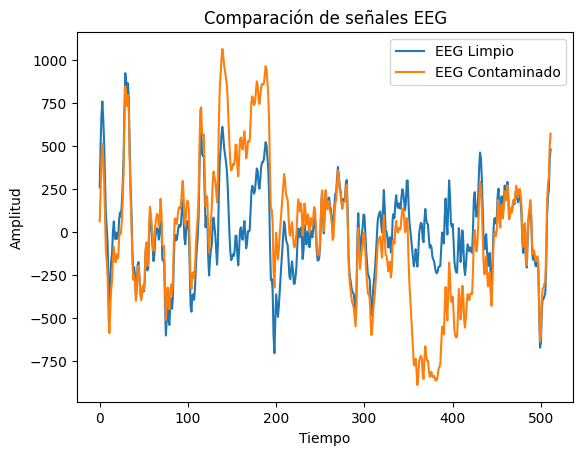

In [2]:
# Se preparon los datos con lo que vamos a trabajar
# Estos datos seran usados para entrenar los modelos
#
(
    clean_data_train_reshaped,
    dirty_data_train_reshaped,
    clean_data_test_reshaped,
    dirty_data_test_reshaped,
) = prepare_data()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 512, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 512, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 256, 64)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 256, 32)       18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 128, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 50, 256, 32)       9248  

2024-01-25 04:35:14.949499: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 471859200 exceeds 10% of free system memory.
2024-01-25 04:35:15.735843: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 471859200 exceeds 10% of free system memory.
2024-01-25 04:35:16.435881: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 471859200 exceeds 10% of free system memory.
2024-01-25 04:35:18.766087: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 471859200 exceeds 10% of free system memory.


1/1 [==============================] - 7s 7s/step - loss: 0.6983 - val_loss: 0.6795
Epoch 2/10


2024-01-25 04:35:20.959082: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 471859200 exceeds 10% of free system memory.


1/1 [==============================] - 6s 6s/step - loss: 0.6795 - val_loss: 0.6606
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.6605 - val_loss: 0.6346
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.6346 - val_loss: 0.5988
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.5987 - val_loss: 0.5509
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.5506 - val_loss: 0.4889
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.4881 - val_loss: 0.4109
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 0.4093 - val_loss: 0.3160
Epoch 9/10
1/1 [==============================] - 5s 5s/step - loss: 0.3127 - val_loss: 0.2035
Epoch 10/10
1/1 [==============================] - 5s 5s/step - loss: 0.1974 - val_loss: 0.0720


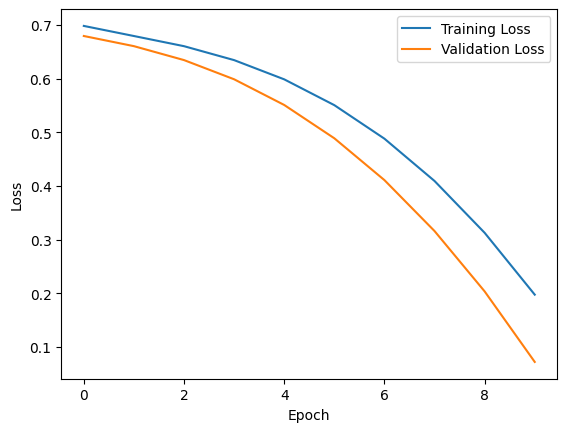

1/1 [==============================] - 0s 328ms/step
Mean MSE: 47539.664800950646
Mean RMSE: 215.87977436670383
Mean MAE: 172.81793413333537
Mean Pearson's correlation: 0.11007358490510093


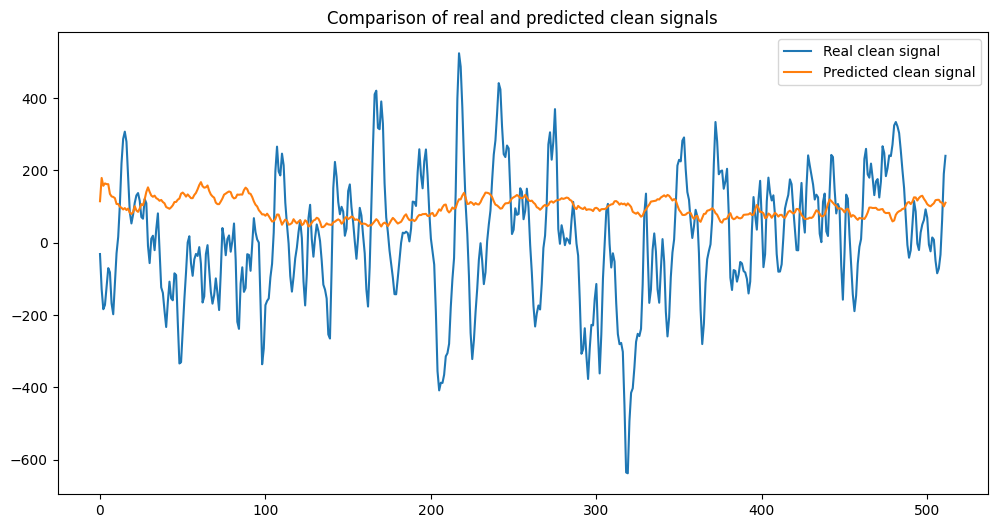

In [3]:
run_model(
    CNNModel,
    10,
    128,
    clean_data_train_reshaped,
    dirty_data_train_reshaped,
    clean_data_test_reshaped,
    dirty_data_test_reshaped
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          328192    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 100, 32)           12416     
                                                                 
 dense (Dense)               (None, 100, 32)           1056      
                                                                 
 dense_1 (Dense)             (None, 100, 512)          16896     
                                                                 
Total params: 407968 (1.56 MB)
Trainable params: 407968 

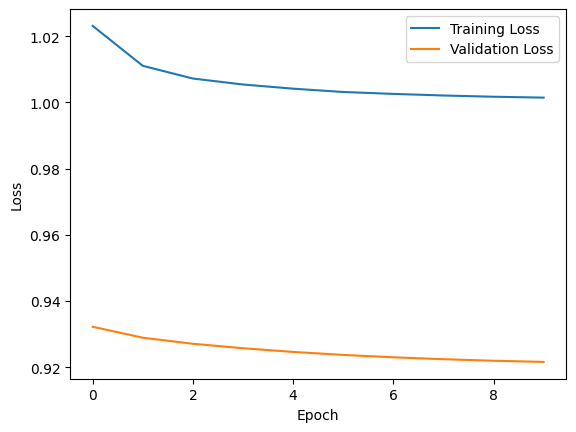

1/1 [==============================] - 1s 792ms/step
Mean MSE: 39990.77995459273
Mean RMSE: 196.92622270608305
Mean MAE: 156.65683208301863
Mean Pearson's correlation: 0.06073834656936721


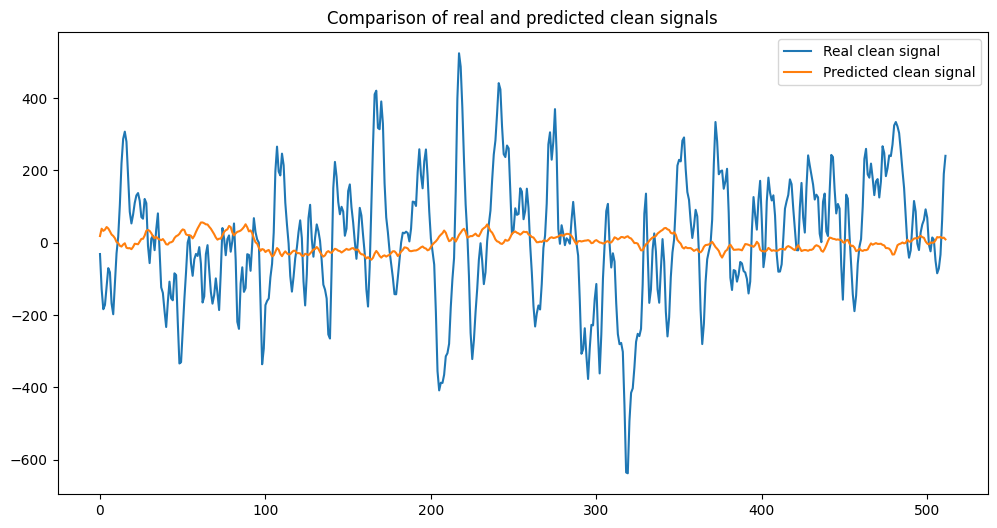

In [4]:
run_model(
    LSTMModel,
    10,
    128,
    clean_data_train_reshaped,
    dirty_data_train_reshaped,
    clean_data_test_reshaped,
    dirty_data_test_reshaped
)